In [ ]:
import os, sys
from copy import deepcopy
from numpy import empty,cumsum,asarray,array,sqrt,float64,dot
import matplotlib.collections as clt
import matplotlib.colors as clrs
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import numpy as np
import argparse

parser = argparse.ArgumentParser(description='My example explanation')
parser.add_argument("-c",
    '--ctrl',
    default="temp",
    help='ctrl file name (default: temp)',
    required=True
)

parser.add_argument(
    '--erange',
    nargs='+', type=float,
    default=[-5,5],
    help='Emin (default: temp)'
)
parser.add_argument(
    '--col',
    nargs='+', type=str,
    default=["bands:black"],
    help='For color plots, specify title of color and color ex- Bulk:white Edge-state:red or spin1:green spin2:red (default: bands:black)'
)
parser.add_argument(
    '--out',
    nargs=1, type=str,
    default="bands.png",
    help='output file top save as. include the format too (default: bands.png)'
)
parser.add_argument(
    '--bgcolor',
    nargs=1, type=str,
    default="white",
    help='baground color (default: white)'
)

parser.add_argument(
    '--fermicenter',
    nargs=1, type=int,
    default=1,
    help='1 for center bands with fermi, 0 if not (default: 1)'
)

parser.add_argument(
    '--units',
    nargs=1, type=str,
    default='eV',
    help='eV or Ry (default: eV)'
) 
parser.add_argument(
    '--lw',
    nargs=1, type=float,
    default=1.2,
    help='line width in bands (default: 1.2)'
) 
parser.add_argument(
    '--v',
    nargs=1, type=int,
    default=0,
    help='Do you really want to see irrerelavant info? if so 1 (default: 0)'
) 



greek_letters = 'alpha','beta','gamma','delta','epsilon','zeta',\
                  'eta','theta','iota','kappa','lambda','mu','nu',\
                  'xi','omicron','pi','rho','stigma','sigma','tau',\
                  'upsilon','phi','chi','psi','omega'

def modl(v):
    vl = asarray(v)
    m = (sum(vl*vl))**(0.5)
    return m

def loadfile(f, mode='r'):
    fd = open(f, mode)
    s = fd.read()
    fd.close()
    return s


def parse_syml(f):
    s = loadfile(f)

    points = {}
    lines = []
    for l in s.splitlines():
        l = l.split()
        if (asarray(l) == '0').all():
            break
        elif len(l) == 0:
            continue
        elif l[0].strip()[0] == '#':
            continue
        elif (l[8] == 'to'):
            if l[7] not in points.keys(): points[l[7]] = array(l[1:4], dtype='float64')
            #else: assert(all(points[l[7]] == array(l[1:4], dtype='float64')))
            if l[9] not in points.keys(): points[l[9]] = array(l[4:7], dtype='float64')
            #else: assert(all(points[l[9]] == array(l[4:7], dtype='float64')))
            lines.append([ l[7], l[9], int(l[0]) ])

    display_points = lines[0][:2]
    dist = [ sqrt( sum((points[lines[0][1]] - points[lines[0][0]])**2) ) ]
    for l in lines[1:]:
        dist.append( sqrt( sum((points[l[1]] - points[l[0]])**2) ) )
        if l[0] != display_points[-1]:
            display_points[-1] += ' ' + l[0]
        display_points.append(l[1])


    for i,p in enumerate(display_points):
        tw = []
        for w in p.split():
            if w.lower() in greek_letters:
                tw.append(r'$\%s$' % w)
            else:
                tw.append(r'$\mathrm{%s}$' % w)
        display_points[i] = ' '.join(tw)


    return display_points, dist
def load_bands_data(f):


    s = loadfile(f)

    info,s = tuple(s.split('\n',1))



    info = info.split()
    num_eig = int(info[0])
    efermi = float(info[1])
    ncol = int(info[2])

    s = s.split()

    lines = []

    l_ind = 0
    p_ind = 0

    #print num_eig

    while ((l_ind + 1) < len(s)):
        num_p = int(s[l_ind])
        #print num_p
        p_ind += 1

        coords = empty((num_p, 3))
        eig    = empty((num_p, num_eig))
        if (ncol>0) : colours = empty((ncol, num_p, num_eig))

        for p in range(num_p):

            coords[p,:] = array(s[p_ind:p_ind+3], dtype='float64')
            #print coords[p,:]

            try:
                p_loc_num_eig = int(s[p_ind+3])

                if (p_loc_num_eig != num_eig):
                    print('The number of eigen values is not uniform.\n\
                    Bad things are likely to happen!')
                    print(p_loc_num_eig, num_eig)
                    sys.exit(1)
                offset = 4
            except ValueError:
                offset = 3

            eig[p,:] = array(s[p_ind + offset : p_ind + offset + num_eig], dtype='float64')
            #print eig[p,:]

            p_ind += offset + num_eig

            for col in range(ncol):
                assert((coords[p,:] == array(s[p_ind:p_ind+3], dtype='float64')).all())
                colours[col,p,:] = array(s[p_ind + 3 : p_ind + 3 + num_eig], dtype='float64')
                p_ind += 3 + num_eig


            #print 'p_ind, s[p_ind-2:p_ind+2]',p_ind, s[p_ind-2:p_ind+2],'\n'

        if (ncol>0):
            colext = colours.min(), colours.max()
            if colext[0] < 0. or colext[1] > 1.:
                for col in range(ncol):
                    for p in range(num_p):
                        for b in range(num_eig):
                            colours[col,p,b] = abs(colours[col,p,b])
                            colours[col,p,b] = min(colours[col,p,b],1.)

        line =  { 'coords':coords, 'eig':eig  }
        if (ncol>0): line['colours'] = colours

        lines.append(deepcopy(line))

        l_ind = p_ind
      

    return efermi, lines
def varcol_plot(x,y, colours=None, linewidths=1):
    pts = tuple(zip(x,y))
    lines = tuple(zip(pts[:-1],pts[1:]))


    if len(x) == len(y):
        if colours != None:
            if (len(x) == len(colours)) or (len(x) == len(colours)-1):
                cols = colours[:len(lines)]
            else:
                #print >> sys.stderr 'the number of colours must be == to len(x) or len(x) - 1'
                print(len(x), len(colours))
                sys.exit(5)
        else:
            cols = None
    else:
        #print >> sys.stderr 'len(x) must be == len(y)'
        sys.exit(6)

    linecol = clt.LineCollection(lines,colors=cols,linewidths=linewidths,capstyle='round')

    return linecol

def go_plot(fl="bnds.prgb",
            sylmfile="syml.prgb",
            ymin=None,
            ymax= None,
            colrs = ["bands:black"],
            bgcol = clrs.to_rgba('white'),
            centre_fermi = 1,
            units="eV",
            yfontsize = None,
            xfontsize = None,
            lwidth = 1,
            marker = "",
            fermi_ls = "--",
            outfile = "",
            verbose = 0):
    #cols=array(cols)
    colors=[]
    names=[]
    for i in colrs:
        colors.append(clrs.to_rgba(i.split(":")[1]))
        names.append(i.split(":")[0])
    cols=array(colors)
    ncol = cols.shape[0]
    assert(ncol == 1 or marker == '')
    
    alfa0 = cols[:,3].sum()/ncol

    factor ={'Ry':1,'eV':13.605698066}[units]
    efermi,sym_lines =  load_bands_data(fl)
    if verbose:
        print('efermi,sym_lines: ',efermi,sym_lines)

    for l in range(len(sym_lines)):
        #NOTE: Don't shuffle this loop and the next multiplication (efermi) later!
        if centre_fermi:
            sym_lines[l]['eig'] -= efermi
        sym_lines[l]['eig'] *= factor
    efermi *= factor
    if centre_fermi:
        efermi = 0.


    if (ymin == None):
        ymin = min([line['eig'].min() for line in sym_lines]) - 0.05*factor

    if (ymax == None):
        ymax = max([line['eig'].max() for line in sym_lines]) + 0.05*factor


    point_names, line_dists = parse_syml(sylmfile)

    if len(sym_lines) != len(line_dists):
        print('The number of lines in the syml file (%i) is different than the number of lines in the bnds file (%i). Exitting!' % (len(sym_lines),len(line_dists)))
        sys.exit(3)



    margins = {'n':0.05, 'e':0.03, 's':0.05, 'w':0.07} # top/north, right/east, bottom/sought, left/west

    widths = (1 - margins['e'] - margins['w'])*asarray(line_dists)/sum(line_dists)
    x_positions = [0] + cumsum(widths).tolist()
    height = (1 - margins['n'] - margins['s'])
    if verbose:
        print('x_positions', x_positions)

    fig = plt.figure()
    ax0 = fig.add_axes([margins['w'], margins['s'], 1 - margins['e'] - margins['w'], 1 - margins['n'] - margins['s'] ], facecolor=bgcol)
    ax0.xaxis.set_ticks_position('none')

    ax0.xaxis.set_ticks( x_positions )

    ax0.yaxis.set_ticks_position('both')
    ax0.minorticks_on()
    ax0.set_xticklabels(point_names)
    ax0.axhline(efermi, linestyle=fermi_ls, linewidth=lwidth, color=(0,0,0,1))

    alfa = empty(ncol)
    kbcol = empty(4)

    for li, line in enumerate(sym_lines):
        r = range(line['coords'].shape[0])

        ax = fig.add_axes([margins['w'] + x_positions[li], margins['s'], widths[li], height], facecolor=(0,0,0,0), frameon=False)
        ax.axvline(0, linestyle=':', color=(0,0,0,1))

        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        ax.set_yticklabels([], visible = False)
        ax.set_xticklabels([], visible = False)

        for b in range(line['eig'].shape[1]):
            if ((ncol>1) and ('colours' in line.keys())):
                if ((ncol -1 )== line['colours'].shape[0] ):
                    nk = line['colours'].shape[1]
                    lcols = []
                    for k in range(nk):
                        alfa[1:] = line['colours'][:,k,b]
                        alfa[0] = max(0.0,1.0-alfa[1:].sum())
                        kbcol = dot(alfa,cols)
                        kbcol *= alfa0/kbcol[3]

                        lcols.append( tuple(kbcol.copy()) )

                    ax.add_collection(varcol_plot(r, line['eig'][:,b].tolist(), colours = lcols, linewidths=lwidth))
                else:
                    print('the number of colours specified and the number colours found in the bands file do not match')
                    sys.exit(7)
            else:
                ax.plot(r, line['eig'][:,b], marker = marker, color=cols[0,:] )


        ax.axis(xmin=r[0], xmax=r[-1], ymin = ymin, ymax = ymax)

    print('')
    ax0.axis(xmin=min(x_positions), xmax=max(x_positions), ymin = ymin, ymax = ymax)


    if xfontsize != None:
        [tl.set_fontsize(xfontsize) for tl in ax0.xaxis.get_ticklabels()]
    if yfontsize != None:
        [tl.set_fontsize(yfontsize) for tl in ax0.yaxis.get_ticklabels()]
    if len(colrs)>1:
        cmap = LinearSegmentedColormap.from_list('mycmap', colors)    

        c_map_ax = fig.add_axes([1.01, 0.2, 0.02, 0.6])
        c_map_ax.axes.get_xaxis().set_visible(False)
        c_map_ax.axes.get_yaxis().set_visible(True)
        norm = mpl.colors.Normalize(vmin=0, vmax=1)

        cbar=mpl.colorbar.ColorbarBase(c_map_ax, cmap=cmap,norm=norm, orientation = 'vertical')
        cbar.set_ticks([0,1])
        cbar.set_ticklabels(names)
        cbar.set_label('Composition')
    if (outfile != '' and outfile != None):
        plt.savefig(outfile,dpi=100, bbox_inches='tight')
    else:
        plt.show()





inputs = parser.parse_args()

if os.path.isfile("syml."+inputs.ctrl) and os.path.isfile("bnds."+inputs.ctrl):
    go_plot(fl="bnds."+inputs.ctrl,sylmfile="syml."+inputs.ctrl,ymin=inputs.erange[0],
      ymax=inputs.erange[1],lwidth=inputs.lw,colrs = inputs.col,
      bgcol=inputs.bgcolor,centre_fermi=inputs.fermicenter,
      units=inputs.units,outfile=inputs.out,verbose=inputs.v
     )
else:
    print("make sure both bnds and syml file exits in this directory and try again")


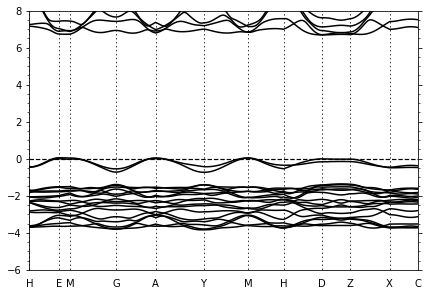

In [47]:
#sample before calling the file
go_plot(fl="bnds.temp",sylmfile="syml.temp",ymin=-6,ymax=8,lwidth=1.2)

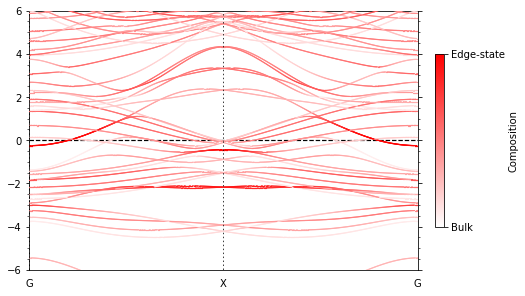

In [45]:
go_plot(fl="bnds.sb",sylmfile="syml.sb",ymin=-6,ymax=6,colrs=["Bulk:white","Edge-state:red"],lwidth=1.2)